In [1]:
import os, math, sys
from sys import stdout

import numpy as np
import matplotlib.pyplot as plt
import openmm.app  as omm_app
import openmm as omm
import simtk.unit as unit
from tqdm import tqdm

import MDAnalysis as mda
from MDAnalysis.analysis import align, rms

### Citing: Most of the openmm data needed for butane and format of this notebook comes from [here](https://fastmbar.readthedocs.io/en/latest/butane_PMF.html).

In [2]:
# Indicates whether to run a simulation or not
SIMULATE = False

## 1. Construct an OpenMM system of butane
We set up the MD molecular system in the format/object required by OpenMM, a class called
[System](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.System.html).

We read in **psf** and **pdb** files for butane: butane.psf and butane.pdb.
The psf file, butane.psf, contains the topology of butane and it is the topolgy file format used by [CHARMM](https://www.charmm.org/).
The file used here is generated using CHARMM.
OpenMM has parsers for topology files with different format from AMBER, CHARMM, etc.

In [3]:
psf = omm_app.CharmmPsfFile('../data/butane.psf')
pdb = omm_app.PDBFile('../data/butane.pdb')
topology = psf.topology

Read CHARMM force field for butane. The CHARMM force field is downloaded from [here](http://mackerell.umaryland.edu/charmm_ff.shtml)

In [4]:
params = omm_app.CharmmParameterSet('../data/top_all35_ethers.rtf',
                                    '../data/par_all35_ethers.prm')

Create a OpenMM system based on the psf file of butane and the CHARMM force field.

In [5]:
system = psf.createSystem(params, nonbondedMethod=omm_app.NoCutoff)

After constructing the OpenMM system of butane, we can save it in an XML formated text file, which can be used later for simulations. Therefore, if we want to use the same system in another script, we can just read the text file in an OpenMM system instead of constructing it again. This file is a readable text file and can be used to see what system information is used.

In [6]:
with open("../output/system.xml", 'w') as file_handle:
    file_handle.write(omm.XmlSerializer.serialize(system))

In [7]:
## read the OpenMM system of butane
with open("../output/system.xml", 'r') as file_handle:
    xml = file_handle.read()
system = omm.XmlSerializer.deserialize(xml)

## read psf and pdb file of butane
psf = omm_app.CharmmPsfFile("../data/butane.psf")
pdb = omm_app.PDBFile('../data/butane.pdb')
topology = psf.topology

# 1.a Set up Metadynamics

In [8]:
# Define Collective Variable
cv = omm.CustomTorsionForce("theta")
cv.addTorsion(3, 6, 9, 13)

# Set metadynamics parameters
biasWidth=0.3
phi = omm_app.metadynamics.BiasVariable(force=cv, minValue=-np.pi, maxValue=np.pi, biasWidth=biasWidth, periodic=True)


# 2. Set up and run the simulation

In order to run simulations in OpenMM, we need to construct an OpenMM [context](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.Context.html), which consists of a system, an integrator and a platform.
The system is the butane system we have constructed above.
The integrator specifies what kind integration method we should use. Here, we will use Langevin dynamics, which corresponds to the [OpenMM.LangevinIntegrator](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.openmm.LangevinIntegrator.html) and the [OpenMM.LangevinMiddleIntegrator](http://docs.openmm.org/latest/api-python/generated/openmm.openmm.LangevinMiddleIntegrator.html). Here, we use the LangevinMiddleIntegrator based on [J. Phys. Chem. A 2019, 123, 28, 6056-6079](https://pubs.acs.org/doi/full/10.1021/acs.jpca.9b02771), closely related to the BAOAB [Proc. R. Soc. A. 472: 20160138](https://royalsocietypublishing.org/doi/abs/10.1098/rspa.2016.0138) scheme.

The platform specifies what kind of hardware we will run simulation on. Here, we choose to use CPUs because the size of the system is quite small.

Then, we initialize a [Simulation](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.app.simulation.Simulation.html), an api for running simulations and reporting results.


In [9]:
## platform
platform = omm.Platform.getPlatformByName('CPU')

T = 300 * unit.kelvin  ## temperature
kbT = unit.BOLTZMANN_CONSTANT_kB * T * unit.AVOGADRO_CONSTANT_NA 
kbT = kbT.value_in_unit(unit.kilojoule_per_mole)

kbT_roomtemp = unit.BOLTZMANN_CONSTANT_kB*unit.AVOGADRO_CONSTANT_NA*300.0*unit.kelvin
kbT_roomtemp = kbT_roomtemp.value_in_unit(unit.kilojoule_per_mole)

# Set up metadynamics
biasFactor = 10
height = 0.1
frequency = 1E2
meta = omm_app.Metadynamics(system, variables=[phi], temperature=T, biasFactor=biasFactor, height=height, frequency=frequency, saveFrequency=frequency, biasDir="../output/traj/")

## integrator
fricCoef = 10/unit.picoseconds ## friction coefficient 
stepsize = 2 * unit.femtoseconds ## integration step size
integrator = omm.LangevinMiddleIntegrator(T, fricCoef, stepsize)
simulation = omm_app.Simulation(topology, system, integrator)

We minimize the energy before running the simulations, and then add "reporters" to track various info on the simulation: the [DCD reporter](http://docs.openmm.org/7.2.0/api-python/generated/simtk.openmm.app.dcdreporter.DCDReporter.html#) records positions of atoms at each 100 steps (in a compressed format), and the [StateDataReporter](http://docs.openmm.org/7.1.0/api-python/generated/simtk.openmm.app.statedatareporter.StateDataReporter.html#) records the potential energy at each 100 steps.

Then, we simulate.

In [10]:
my_state = "../output/traj/state_metad.txt"
my_dcd = "../output/traj/traj_metad.dcd"
my_free_energy = "../output/traj/free_energy.npz"

if SIMULATE:
    simulation.context.setPositions(pdb.positions)
    if psf.boxVectors is not None:
        print("we got box vectors!")
        simulation.context.setPeriodicBoxVectors(*psf.boxVectors)
    simulation.minimizeEnergy()
    
    simulation.reporters.append(omm_app.DCDReporter(my_dcd, int(1E1)))
    simulation.reporters.append(omm_app.StateDataReporter(my_state, 1E1, step=True, potentialEnergy=True))
    simulation.reporters.append(omm_app.StateDataReporter(stdout, 1E6, step=True, potentialEnergy=True))
    meta.step(simulation, 1E7)
    np.savez(my_free_energy, free_energy=meta.getFreeEnergy())

## 3. RMSD-align trajectory frames to normalize out rotations and translations



In [11]:
# For RMSD aligning, setting a 'mobile' and 'reference' trajectory
mobile = mda.Universe("../data/butane.psf", my_dcd)
ref = mda.Universe("../data/butane.psf", my_dcd)
mobile.trajectory[-1]
ref.trajectory[0]
align.AlignTraj(mobile, ref, filename="../output/traj/traj_aligned_metad.dcd").run()
mobile = mda.Universe("../data/butane.psf", "../output/traj/traj_aligned_metad.dcd")


/home/luke/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/home/luke/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/DCD.py:448: UserWarning: No dimensions set for current frame, zeroed unitcell will be written
  warnings.warn(wmsg)


# 4. Compute dihedral angle

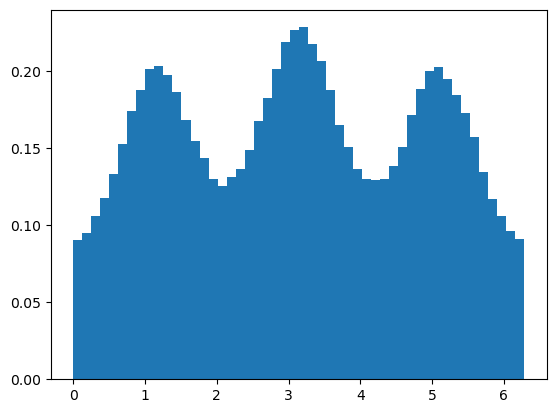

In [12]:
from MDAnalysis.analysis.dihedrals import Dihedral

carbons = mobile.atoms[[3, 6, 9, 13]]
theta = Dihedral([carbons]).run().results.angles.flatten()*(np.pi/180.)
np.savetxt(f"../output/dihedral/dihedral_metad.csv", theta, fmt = "%.5f", delimiter = ",")
dihedrals = np.loadtxt( f"../output/dihedral/dihedral_metad.csv", delimiter = ",")

# shift dihedrals from [-pi, pi] to [0, 2pi]
dihedrals[dihedrals < 0] = dihedrals[dihedrals < 0] + 2*np.pi

_ = plt.hist(dihedrals, bins=50, density=True)

# Check the metadynamics free energy

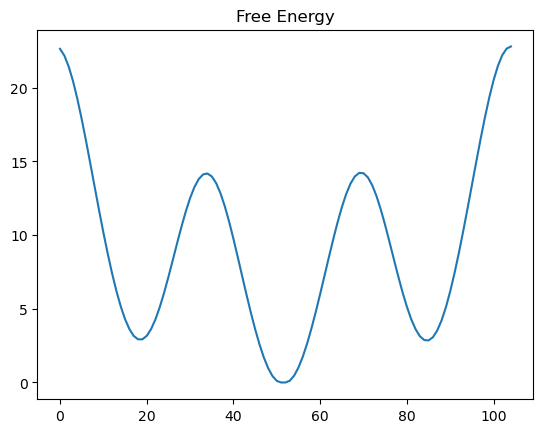

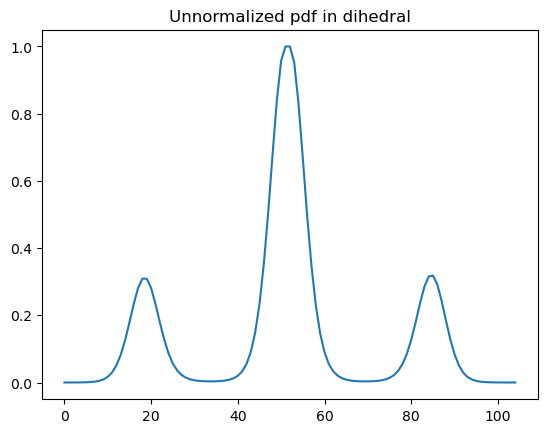

In [13]:
free_energy = np.load(my_free_energy)["free_energy"]
free_energy = free_energy - np.min(free_energy)


# shifting free energy values from [-pi, pi] to [0, 2pi]
free_energy = np.roll(free_energy, int(len(free_energy)/2))

plt.figure()
plt.title("Free Energy")
plt.plot(free_energy)

plt.figure()
plt.title("Unnormalized pdf in dihedral")
plt.plot(np.exp(-free_energy/kbT))

Select just the atoms used for the dihedral and keep their positions in a numpy array, as well as the potential and temperature for the trajectory

**Note**: Only saving the last half of the trajectory to numpy, to keep the dataset that is ``converged'' with respect to the well-tempered metadynamics biasing

In [14]:
coords = mobile.trajectory.timeseries(mobile.atoms).swapaxes(0, 1)
carbon_coords = mobile.trajectory.timeseries(carbons).swapaxes(0, 1)
print(coords.shape)
print(carbon_coords.shape)
N = coords.shape[0]

data = carbon_coords.reshape(N, 12)
data = data[-200000:, :]

# Saving full atomic coordinate data just in case it's helpful
data_all_atom = coords.reshape(N, 42)
data_all_atom = data_all_atom[-200000:]

print(f"number of data points saved: {data.shape[0]}")
potential = np.loadtxt("../output/traj/state_metad.txt", delimiter=',')[:, 1]
dihedrals_save = dihedrals[-200000:]
potential_save = potential[-200000:]
fname = "../output/butane_metad.npz"
np.savez(fname, data=data, data_all_atom=data_all_atom, dihedrals=dihedrals_save, potential=potential_save, kbT=kbT, kbT_roomtemp=kbT_roomtemp, free_energy=meta.getFreeEnergy(), biasFactor=biasFactor, biasWidth=biasWidth, height=height, frequency=frequency)

(1000000, 14, 3)
(1000000, 4, 3)
number of data points saved: 200000
